<a href="https://colab.research.google.com/github/dowrave/RoadToImageSeg_GAN/blob/main/220510_Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[텐서플로우 튜토리얼](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)


In [21]:
# pix2pix 모델 빌드하는 것만 짚고 넘어감. 해당 튜토리얼은 데이터가 없어서 실행 불가능(ㄲㅂ)
import tensorflow as tf
import os

In [2]:
OUTPUT_CHANNELS = 3

In [8]:
def downsample(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0. , 0.02) # mean, std

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding = 'same',
                             kernel_initializer = initializer, use_bias = False)
  )
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [5]:
def upsample(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding = 'same',
                                      kernel_initializer = initializer,
                                      use_bias = False)
  )

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [9]:
# 생성기(Generator())
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3]) # 이건 뭐 이미지마다 바뀌겠죠?

  '''downsample(filter, size) 였다. strides는 2니까 크기 1/2씩 줄어듦'''
  down_stack = [
                downsample(64, 4, apply_batchnorm= False), # (bs, 128, 128, 64)
                downsample(128, 4), # (bs, 64, 64, 128)
                downsample(256, 4), # (bs, 32, 32, 256)
                downsample(512, 4), # (bs, 16, 16, 512)
                downsample(512, 4), # (bs, 8, 8, 512)
                downsample(512, 4), # (bs, 4, 4, 512)
                downsample(512, 4), # (bs, 2, 2, 512)
                downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [ # 왜 여기서 1024가 되는거임? 512가 아니라? -> 이게 Skip Connection 때문인 것 같다! Upsampling은 진행되는 특성 + Downsampling의 특성을 받으니까
              upsample(512, 4, apply_dropout = True), # (bs, 2, 2, 1024)
              upsample(512, 4, apply_dropout = True), # (bs, 4, 4, 1024)
              upsample(512, 4, apply_dropout = True), # (bs, 8, 8, 1024)
              upsample(512, 4), # (bs, 16, 16, 1024)
              upsample(256, 4), # (bs, 32, 32, 512)
              upsample(128, 4), # (bs, 64, 64, 256)
              upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides = 2,
                                         padding = 'same',
                                         kernel_initializer = initializer,
                                         activation = 'tanh') # (bs, 256, 256, OUTPUT_CHANNELS)
  
  x = inputs # Input의 구조를 정의하는 변수가 inputs이었음

  # Downsampling Through the Model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1]) # reversed : 시퀀스의 순서를 뒤집음 / 가장 마지막층 (bs, 1, 1, 512)은 제외됨

  # Upsampling & Skip Connection
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip]) # Skip Connection은 Concatenate()로 구현한다.
  
  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)

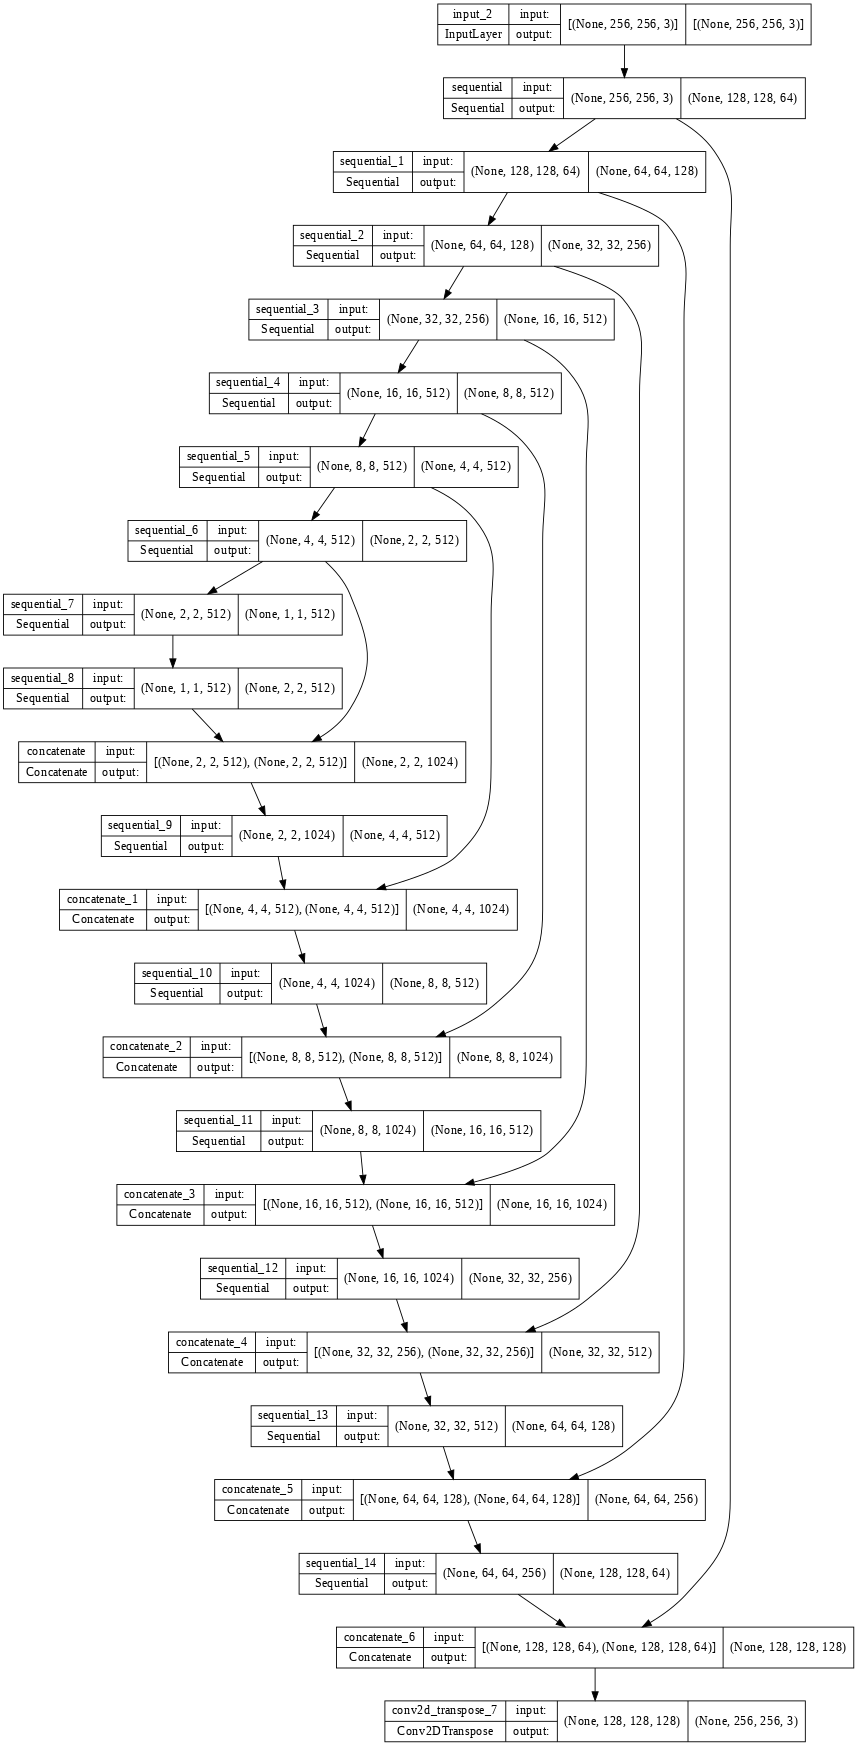

In [10]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

### 생성기 손실
- gan_loss + lambda * l1_loss

In [11]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + LAMBDA * l1_loss

  return total_gen_loss, gan_loss, l1_loss

### 판별자 빌드
- PatchGAN
- 각 블록은 Conv -> BatchNorm -> LeakyReLU
- 마지막 레이어 이후 shape는 bs, 30, 30, 1
- 출력의 각 30x30 patch는 입력 이미지의 70x70을 분류함
- 입력은 2개 : 진짜 이미지와 가짜 이미지
  - 이 두 입력은 `tf.concat([inp, tar], axis = -1)`로 연결됨

In [16]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape = [256, 256, 3], name = 'input_image')
  tar = tf.keras.layers.Input(shape = [256, 256, 3], name = 'target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels * 2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)


  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) #(bs, 34, 34, 256) # 패딩을 또 해주네?
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1,
                                kernel_initializer = initializer,
                                use_bias = False)(zero_pad1) # (bs, 31, 31, 512) # 4*4 필터로 34*34를 돌아다닌다고 생각해보자. 한 변이 31임
  
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
  
  last = tf.keras.layers.Conv2D(1, 4, strides = 1,
                                kernel_initializer = initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs = last)

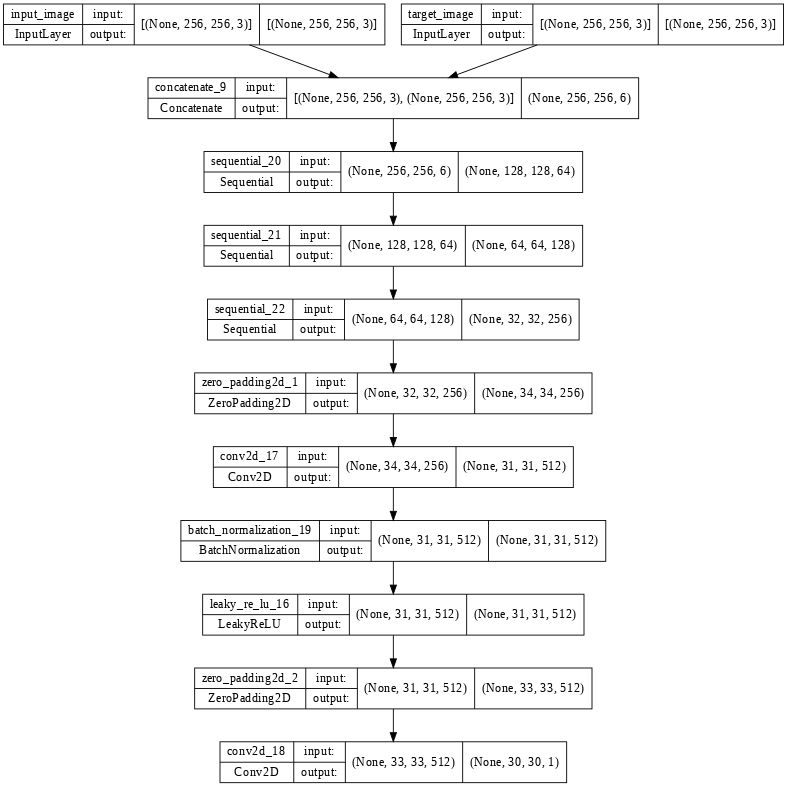

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 64)

### 판별자 손실(Discriminator Loss)
- 진짜, 생성된 이미지 두 입력을 받음
- real_loss : 진짜 이미지 & 1의 배열의 시그모이드 교차 엔트로피 손실
- generated_loss : 생성 & 0의 배열의 시그모이드 교차 엔트로피 손실
- total_loss = real_loss와 generated_loss 의 합

In [18]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### 옵티마이저 및 체크포인트

In [20]:
# G를 2로 나눠준다고 하지 않음?
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)